<img src="https://i.ibb.co/c25YDtz/06b6e0cfbe08f55ffbe9dc6df32e06c4-ce-2430x1516x0x65-cropped-960x600.jpg">


# Description

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 


## Details & Description of Features:

   - PassengerID
   - Survived - (0 = No, 1 = Yes)
   - Pclass - Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)
   - Name
   - Sex
   - Age
   - SibSp - Number of Siblings/Spouses Aboard
   - Parch - Number of Parents/Children Aboard
   - Ticket - Ticket Number
   - Fare - Passenger Fare in British pound
   - Cabin - Cabin Number
   - Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Additional Notes:

   - Pclassis a proxy for socio-economic status (SES) : 1st ~ Upper, 2nd ~ Middle, 3rd ~ Lower
   - Fare is in Pre-1970 British Pounds : Conversion Factors: £1 = 12s (shillings) = 240d (pence) and 1s = 20d
   - Sibling : Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
   - Spouse : Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
   - Parent : Mother or Father of Passenger Aboard Titanic
   - Child : Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic


## 1. Preparation

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(rc={"font.size":18,"axes.titlesize":30,"axes.labelsize":18,
            "axes.titlepad":22, "axes.labelpad":18, "legend.fontsize":15,
            "legend.title_fontsize":15, "figure.titlesize":35})

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = train[['Survived', 'PassengerId']].set_index('PassengerId')

### 1.1 Explore the data

In [4]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [7]:
corr = test.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000


### 1.2 Create full data

In [8]:
full_data = [train, test]

data = pd.concat([train, test])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2 Feature Engineering and Data Preprocessing

### 2.1 Magic feature creation

Find how many people survived with the same ticket.

In [9]:
magic_feature = train[['Ticket', 'Survived']].groupby('Ticket').sum()
magic_feature.columns = ['Magic']
magic_feature.head()

,Magic
Ticket,
110152,3
110413,2
110465,0
110564,1
110813,1


In [10]:
data = data.merge(magic_feature, on='Ticket', how='left')
data['Magic'] = data['Magic'].fillna(0)
data['Magic'] = data['Magic'].astype(int)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Magic
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


Text(0.5, 1.0, "Survived depends of 'Magic'")

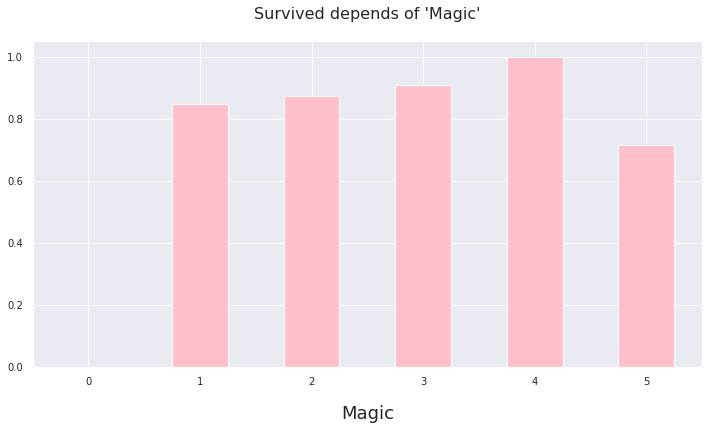

In [11]:
ax = data.groupby('Magic')['Survived'].mean().plot.bar(figsize=(12, 6), fontsize=10, rot=0, color="pink")
ax.set_title("Survived depends of 'Magic'", fontdict={'fontsize': 16, 'fontweight': 'medium'})

### 2.2 Categorical to binary. SEX

In [12]:
data['Sex'] = pd.get_dummies(data['Sex'], drop_first=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Magic
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0


Text(0.5, 1.0, "Survived depends of 'Sex'")

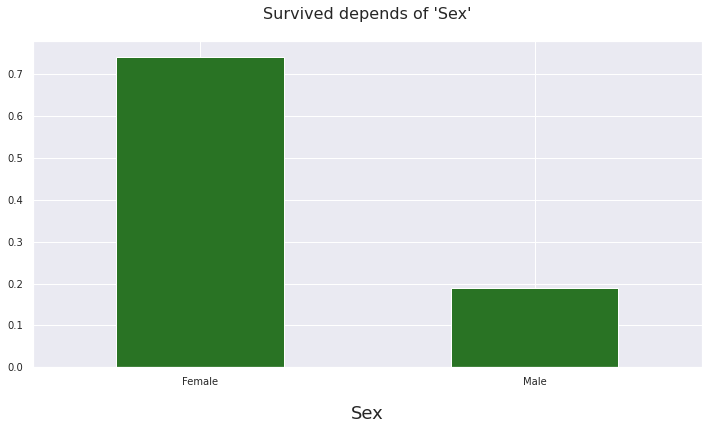

In [13]:
ax = data.groupby('Sex')['Survived'].mean().plot.bar(figsize=(12, 6), 
                                                fontsize=10, rot=0, color="#297324")
ax.set_xticklabels(['Female', 'Male'])
ax.set_title("Survived depends of 'Sex'", fontdict={'fontsize': 16, 'fontweight': 'medium'})

### 2.3 Get title of name. NAME

In [14]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""


In [15]:
data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                             'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')


encoder = LabelEncoder()
data['Title'] = encoder.fit_transform(data['Title'])
data = data.drop('Name', axis=1)


data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Magic,Title
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2
1,2,1.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1,3
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1.0,1,0,35.0,1,0,113803,53.1000,C123,S,1,3
4,5,0.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0,2


Text(0.5, 1.0, "Survived depends of 'Title'")

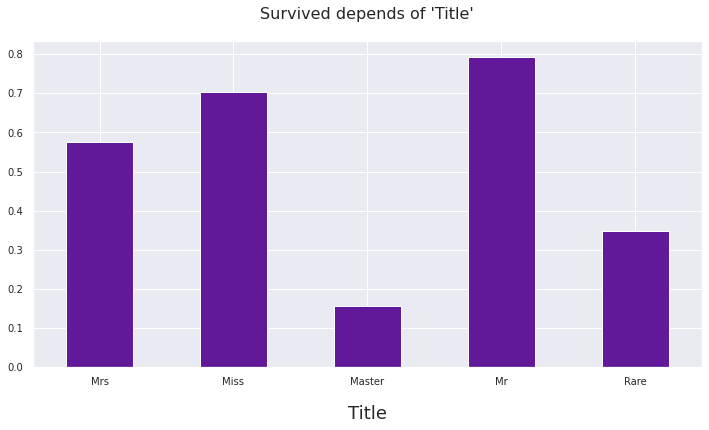

In [16]:
ax = data.groupby('Title')['Survived'].mean().plot.bar(figsize=(12, 6), 
                                                fontsize=10, rot=0, color="#621999")
ax.set_xticklabels(['Mrs', 'Miss', 'Master', 'Mr', 'Rare'])
ax.set_title("Survived depends of 'Title'", fontdict={'fontsize': 16, 'fontweight': 'medium'})

### 2.4 Numeric to Label. Fare

In [17]:
# Fill NaN with median
data['Fare'].fillna(data['Fare'].dropna().median(), inplace=True)

# Group up numeric feature
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [18]:
data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[ data['Fare'] > 31, 'Fare'] = 3
data['Fare'] = data['Fare'].astype(int)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Magic,Title
0,1,0.0,3,1,22.0,1,0,A/5 21171,0,NaN,S,0,2
1,2,1.0,1,0,38.0,1,0,PC 17599,3,C85,C,1,3
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,1,NaN,S,1,1
3,4,1.0,1,0,35.0,1,0,113803,3,C123,S,1,3
4,5,0.0,3,1,35.0,0,0,373450,1,NaN,S,0,2


Text(0.5, 1.0, "Survived depends of 'Fare'")

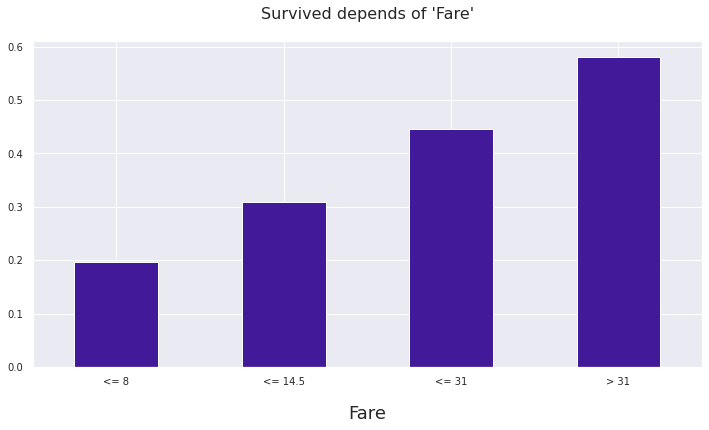

In [19]:
ax = data.groupby('Fare')['Survived'].mean().plot.bar(figsize=(12, 6), 
                                                fontsize=10, rot=0, color="#421999")
ax.set_xticklabels(['<= 8', '<= 14.5', '<= 31', '> 31'])
ax.set_title("Survived depends of 'Fare'", fontdict={'fontsize': 16, 'fontweight': 'medium'})

### 2.5 Group tickets by number and chars. Tickets

In [20]:
name_tickets = []
number_tickets = []
type_tickets = []

for i in range(len(data)):
    row = data.iloc[i]
    ticket = row['Ticket']
    
    splits = ticket.split()
    
    name_ticket = None
    number_ticket = None
    
    if len(splits) >= 2:
        number_ticket = int(splits[-1])
        name_ticket = ''.join(splits[:-1]).split('/')[0].lower().replace('.', '')
        type_ticket = ''.join(splits[:-1])[0:3].replace('/', '').replace('.', '').replace(' ', '')
    else:
        split = splits[0]
        type_ticket = 'number'
        
        if split.isdigit():
            name_ticket = 'other'
            number_ticket = int(split)
        else:
            name_ticket = split.lower()
            number_ticket = -999999
    
    name_tickets.append(name_ticket)
    number_tickets.append(number_ticket)
    type_tickets.append(type_ticket)
    

In [21]:
data['TypeTicket'] = type_tickets
data['NameTicket'] = name_tickets
data['NumberTicket'] = number_tickets


encoder = LabelEncoder()
data['TypeTicket'] = encoder.fit_transform(data['TypeTicket'])

# encoder = LabelEncoder()
# data['NumberTicket'] = encoder.fit_transform(data['NumberTicket'])

encoder = LabelEncoder()
data['NameTicket'] = encoder.fit_transform(data['NameTicket'])


data = data.drop('Ticket', axis=1)

data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket
0,1,0.0,3,1,22.0,1,0,0,NaN,S,0,2,3,0,21171
1,2,1.0,1,0,38.0,1,0,3,C85,C,1,3,11,14,17599
2,3,1.0,3,0,26.0,0,0,1,NaN,S,1,1,18,23,3101282
3,4,1.0,1,0,35.0,1,0,3,C123,S,1,3,23,12,113803
4,5,0.0,3,1,35.0,0,0,1,NaN,S,0,2,23,12,373450


Text(0.5, 1.0, "Survived depends of 'TypeTicket'")

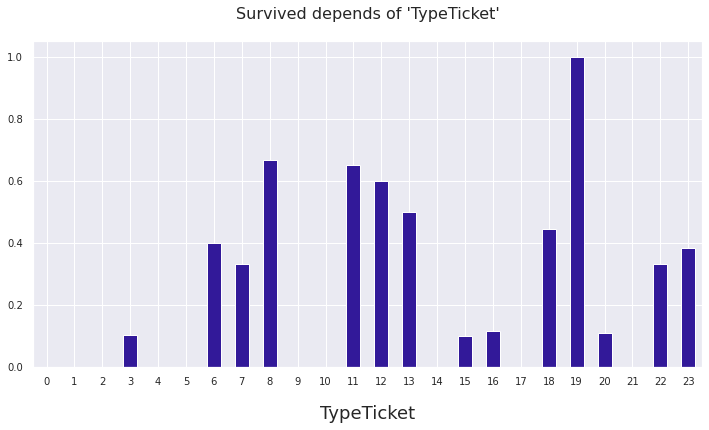

In [22]:
ax = data.groupby('TypeTicket')['Survived'].mean().plot.bar(figsize=(12, 6), 
                                                fontsize=10, rot=0, color="#321999")
ax.set_title("Survived depends of 'TypeTicket'", fontdict={'fontsize': 16, 'fontweight': 'medium'})


### 2.6 Does the passenger have a cab number?

In [23]:
data['Cabin'].isnull().sum()

1014

In [24]:
data['HasCabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

data = data.drop('Cabin', axis=1)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin
0,1,0.0,3,1,22.0,1,0,0,S,0,2,3,0,21171,0
1,2,1.0,1,0,38.0,1,0,3,C,1,3,11,14,17599,1
2,3,1.0,3,0,26.0,0,0,1,S,1,1,18,23,3101282,0
3,4,1.0,1,0,35.0,1,0,3,S,1,3,23,12,113803,1
4,5,0.0,3,1,35.0,0,0,1,S,0,2,23,12,373450,0


### 2.7 Categorical to Label. Embarked

In [25]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [26]:
freq_port = data['Embarked'].dropna().mode()[0]
data['Embarked'].fillna(freq_port, inplace=True)

data['Embarked'] = data['Embarked'].astype(str)
encoder = LabelEncoder()
data['Embarked'] = encoder.fit_transform(data['Embarked'])

data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin
0,1,0.0,3,1,22.0,1,0,0,2,0,2,3,0,21171,0
1,2,1.0,1,0,38.0,1,0,3,0,1,3,11,14,17599,1
2,3,1.0,3,0,26.0,0,0,1,2,1,1,18,23,3101282,0
3,4,1.0,1,0,35.0,1,0,3,2,1,3,23,12,113803,1
4,5,0.0,3,1,35.0,0,0,1,2,0,2,23,12,373450,0


[Text(0, 0, 'S'), Text(1, 0, 'C'), Text(2, 0, 'Q')]

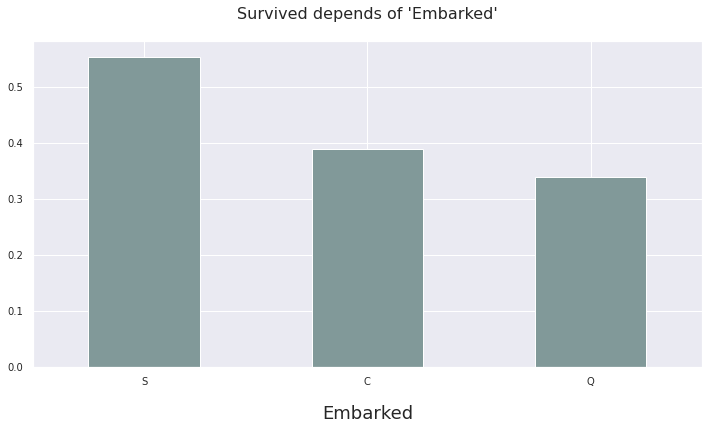

In [27]:
ax = data.groupby('Embarked')['Survived'].mean().plot.bar(figsize=(12, 6), 
                                                fontsize=10, rot=0, color="#819999")
ax.set_title("Survived depends of 'Embarked'", fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_xticklabels(['S', 'C', 'Q'])

### 2.8 Feature engineering. FamilySize and IsAlone

In [28]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin,FamilySize,IsAlone
0,1,0.0,3,1,22.0,1,0,0,2,0,2,3,0,21171,0,2,0
1,2,1.0,1,0,38.0,1,0,3,0,1,3,11,14,17599,1,2,0
2,3,1.0,3,0,26.0,0,0,1,2,1,1,18,23,3101282,0,1,1
3,4,1.0,1,0,35.0,1,0,3,2,1,3,23,12,113803,1,2,0
4,5,0.0,3,1,35.0,0,0,1,2,0,2,23,12,373450,0,1,1


[Text(0, 0, 'Not Alone'), Text(1, 0, 'Alone')]

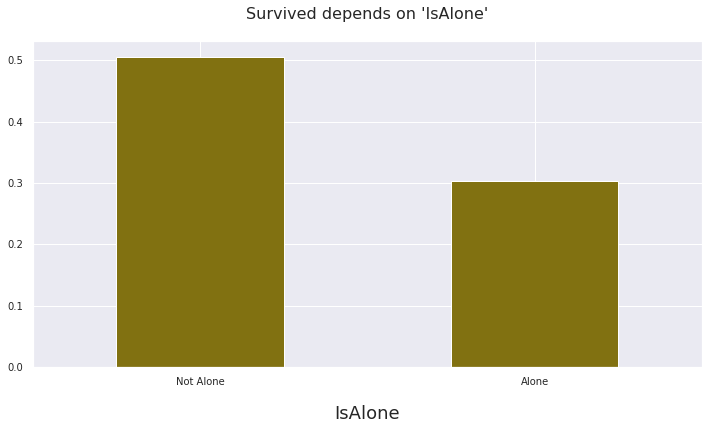

In [29]:
ax = data.groupby('IsAlone')['Survived'].mean().plot.bar(figsize=(12, 6),
                                                fontsize=10, rot=0, color="#817111")
ax.set_title("Survived depends on 'IsAlone'", fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_xticklabels(['Not Alone', 'Alone'])

### 2.9 Working with feature: AGE

#### 1 Fill NaN

##### 1.1 fill Nan with distribution

In [30]:
data_age_dist = data.copy()
data_age_dist.drop('Survived', axis=1, inplace=True)

In [31]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [32]:
ages = full_data[1][['Age', 'PassengerId']].append(full_data[0][['Age', 'PassengerId']]).set_index('PassengerId').sort_index()

data_age_dist = data_age_dist.set_index('PassengerId')
data_age_dist['Age'] = ages
data_age_dist.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,,
1,3,1,22,1,0,0,2,0,2,3,0,21171,0,2,0
2,1,0,38,1,0,3,0,1,3,11,14,17599,1,2,0
3,3,0,26,0,0,1,2,1,1,18,23,3101282,0,1,1
4,1,0,35,1,0,3,2,1,3,23,12,113803,1,2,0
5,3,1,35,0,0,1,2,0,2,23,12,373450,0,1,1


##### 1.2 Fill NaN with prediction

In [33]:
data_age_pred = data.copy()
data_age_pred.drop('Survived', axis=1, inplace=True)

In [34]:
data_train = data_age_pred[data_age_pred['Age'].notnull()]
data_test = data_age_pred[data_age_pred['Age'].isnull()]

target_age = data_train['Age']

data_train = data_train.drop('Age', axis=1)
data_test = data_test.drop('Age', axis=1)


In [35]:
model = ExtraTreesRegressor(random_state=42, max_depth=30, n_estimators=1000)
model.fit(data_train, target_age)
predicted_values_train = model.predict(data_train)
predicted_values = model.predict(data_test)
mean_squared_error(predicted_values_train, target_age, squared=False)


0.09212526952957904

In [36]:
data_train['Age'] = target_age
data_test['Age'] = np.array(round(pd.Series(predicted_values), 2))
data_age_pred = pd.concat([data_test, data_train]).sort_index()
data_age_pred = data_age_pred.set_index('PassengerId')
data_age_pred.isnull().sum()


Pclass          0
Sex             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Magic           0
Title           0
TypeTicket      0
NameTicket      0
NumberTicket    0
HasCabin        0
FamilySize      0
IsAlone         0
Age             0
dtype: int64

#### 2 Numerical to categorical

In [37]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.546296
1,"(16.0, 32.0]",0.351770
2,"(32.0, 48.0]",0.370518
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [38]:
def num_to_cat_age(dataframe):
    dataframe.loc[ dataframe['Age'] <= 16, 'Age'] = 0
    dataframe.loc[(dataframe['Age'] > 16) & (dataframe['Age'] <= 32), 'Age'] = 1
    dataframe.loc[(dataframe['Age'] > 32) & (dataframe['Age'] <= 48), 'Age'] = 2
    dataframe.loc[(dataframe['Age'] > 48) & (dataframe['Age'] <= 64), 'Age'] = 3
    dataframe.loc[ dataframe['Age'] > 64, 'Age'] = 4
    dataframe['Age'] = dataframe['Age'].astype(int)
    
    return dataframe

In [39]:
data_age_dist = num_to_cat_age(data_age_dist)
data_age_dist.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,,
1,3,1,1,1,0,0,2,0,2,3,0,21171,0,2,0
2,1,0,2,1,0,3,0,1,3,11,14,17599,1,2,0
3,3,0,1,0,0,1,2,1,1,18,23,3101282,0,1,1
4,1,0,2,1,0,3,2,1,3,23,12,113803,1,2,0
5,3,1,2,0,0,1,2,0,2,23,12,373450,0,1,1


In [40]:
data_age_pred = num_to_cat_age(data_age_pred)
data_age_pred.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NameTicket,NumberTicket,HasCabin,FamilySize,IsAlone,Age
PassengerId,,,,,,,,,,,,,,,
1,3,1,1,0,0,2,0,2,3,0,21171,0,2,0,1
2,1,0,1,0,3,0,1,3,11,14,17599,1,2,0,2
3,3,0,0,0,1,2,1,1,18,23,3101282,0,1,1,1
4,1,0,1,0,3,2,1,3,23,12,113803,1,2,0,2
5,3,1,0,0,1,2,0,2,23,12,373450,0,1,1,2


### 2.10 Data prepared

In [41]:
data_prepared = data_age_pred.copy()
data_prepared = data_prepared.merge(target, on='PassengerId', how='left')
data_prepared.drop(['NameTicket'], axis=1, inplace=True)

In [42]:
corr = data_prepared.corr()
corr.style.background_gradient(cmap='coolwarm')

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NumberTicket,HasCabin,FamilySize,IsAlone,Age,Survived
Pclass,1.000000,0.124617,0.060832,0.018322,-0.651111,0.185479,-0.318503,-0.210771,0.062092,0.278663,-0.713857,0.050027,0.147393,-0.410138,-0.338481
Sex,0.124617,1.000000,-0.109609,-0.213125,-0.234848,0.097960,-0.305961,0.023785,-0.012885,0.051361,-0.137396,-0.188583,0.284537,0.072637,-0.543351
SibSp,0.060832,-0.109609,1.000000,0.373587,0.383103,0.065567,0.085086,-0.192377,-0.115147,0.024160,-0.009064,0.861952,-0.591077,-0.273898,-0.035322
Parch,0.018322,-0.213125,0.373587,1.000000,0.371350,0.044772,0.239702,-0.086415,-0.095893,-0.036346,0.036806,0.792296,-0.549022,-0.140186,0.081629
Fare,-0.651111,-0.234848,0.383103,0.371350,1.000000,-0.111848,0.466253,0.068184,-0.164813,-0.195955,0.502140,0.454957,-0.557708,0.114255,0.295875
Embarked,0.185479,0.097960,0.065567,0.044772,-0.111848,1.000000,-0.124198,-0.021303,0.024082,0.193947,-0.205733,0.067598,0.061649,-0.060757,-0.167675
Magic,-0.318503,-0.305961,0.085086,0.239702,0.466253,-0.124198,1.000000,-0.063187,0.006047,-0.131325,0.313672,0.186979,-0.330969,-0.037880,0.722482
Title,-0.210771,0.023785,-0.192377,-0.086415,0.068184,-0.021303,-0.063187,1.000000,0.001582,-0.060056,0.130927,-0.173770,-0.005052,0.485903,-0.071174
TypeTicket,0.062092,-0.012885,-0.115147,-0.095893,-0.164813,0.024082,0.006047,0.001582,1.000000,0.073092,0.002906,-0.128151,0.035327,-0.002963,0.013922
NumberTicket,0.278663,0.051361,0.024160,-0.036346,-0.195955,0.193947,-0.131325,-0.060056,0.073092,1.000000,-0.184050,-0.003974,0.041236,-0.098390,-0.092955


### 2.11 Feature generating ageClass

In [43]:
data_prepared['AgeClass'] = data_prepared.Age * data_prepared.Pclass
data_prepared.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Magic,Title,TypeTicket,NumberTicket,HasCabin,FamilySize,IsAlone,Age,Survived,AgeClass
PassengerId,,,,,,,,,,,,,,,,
1,3,1,1,0,0,2,0,2,3,21171,0,2,0,1,0.0,3
2,1,0,1,0,3,0,1,3,11,17599,1,2,0,2,1.0,2
3,3,0,0,0,1,2,1,1,18,3101282,0,1,1,1,1.0,3
4,1,0,1,0,3,2,1,3,23,113803,1,2,0,2,1.0,2
5,3,1,0,0,1,2,0,2,23,373450,0,1,1,2,0.0,6


## 3 Mean Encoding

In [ ]:
def mean_encoding(column):
    partition = data_prepared.groupby(column)['Survived'].mean()
    encoded = data_prepared[column].map(partition)
    
    return encoded

In [ ]:
for column in data_prepared.columns:
    if column == 'Survived':
        continue
        
    data_prepared[column] = mean_encoding(column)

data_prepared.head()

In [ ]:
data_prepared['Parch'] = data_prepared['Parch'].fillna(0.5)
data_prepared['TypeTicket'] = data_prepared['TypeTicket'].fillna(0.5)

In [ ]:
data_prepared.isnull().sum()

## 4 Divide data to train/test + shuffle

In [44]:
features_train = data_prepared[data_prepared['Survived'].notnull()]
features_test = data_prepared[data_prepared['Survived'].isnull()]

features_train = features_train.drop('Survived', axis=1)
features_test = features_test.drop('Survived', axis=1)

target_train = data_prepared['Survived'].dropna()

### 4.1 Shuffle data?

In [ ]:
def shuffle_data(features, target, shuffle=True):
    features['target'] = target
    
    if shuffle:
        features = features.sample(frac=1)
    else:
        features = features.sort_index()
        
    target = features['target']
    features.drop(['target'], axis=1, inplace=True)
    
    return features, target


In [ ]:
features_train, target_train = shuffle_data(features_train, target_train, True)


## 5 Checking Feature Importance by Correlation Analysis

In [45]:
corr_mat = data_prepared.astype(float).corr()
corr_mat_fil = corr_mat.loc[:, 'Survived'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])

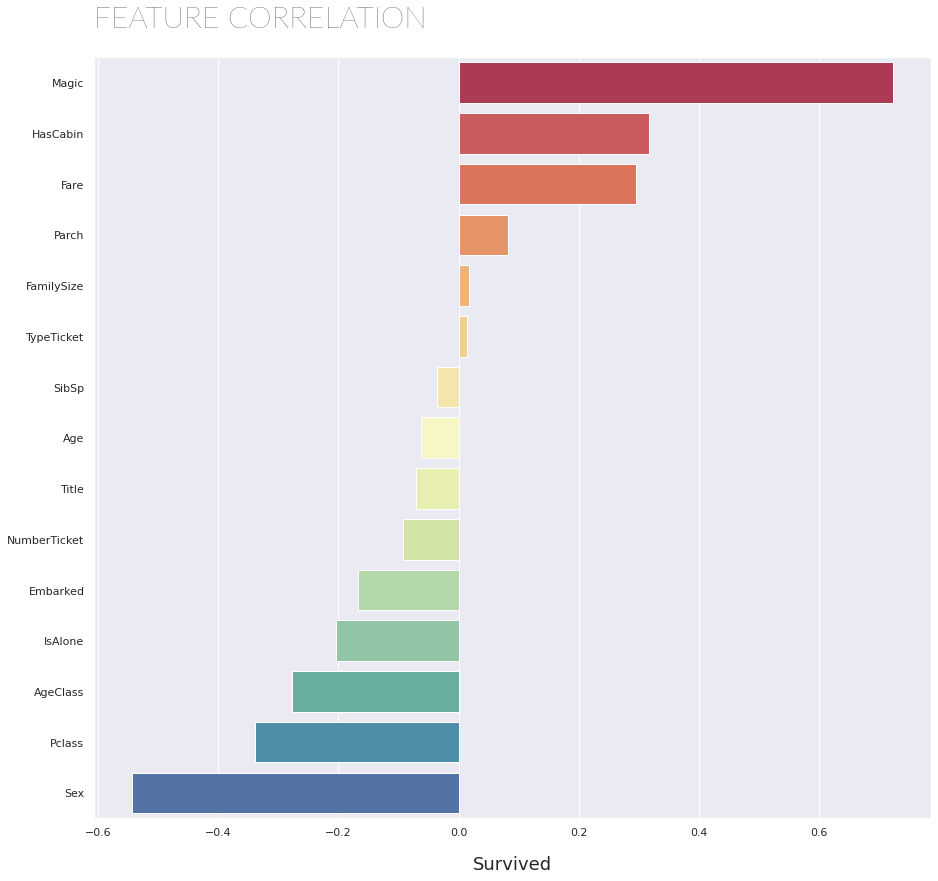

In [46]:
plt.figure(figsize=(15,14))
bar = sns.barplot(x=corr_mat_fil.Survived, y=corr_mat_fil.index, data=corr_mat_fil, palette="Spectral")
title = bar.set_title("FEATURE CORRELATION", x=0.0, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=30)

## 6 Classification Survived

In [47]:
def save_prediction(prediction, name_of_file=None):
    if name_of_file is None:
        name_of_file = 'submission.csv'
    
    test['Survived'] = pd.Series(prediction).astype(int)
    result = test[['PassengerId', 'Survived']].sort_values('PassengerId')
    result.to_csv(name_of_file, index=False)
    
    print(f"Predition was saved on file: {name_of_file}")

### 6.1 ExtraTreesClassifier

In [52]:
param_test1 = {
    'max_depth': [5, 6, 7, 8, 9, 10],
}

gETC = RandomizedSearchCV(estimator = ExtraTreesClassifier(n_estimators = 500), 
                       param_distributions = param_test1, 
                       scoring='f1',
                       cv=10, verbose = 5, 
                       n_iter=200)
gETC.fit(features_train, target_train)

/home/magleb/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=200. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END ...................................max_depth=5; total time=   0.4s
[CV 2/10] END ...................................max_depth=5; total time=   0.4s
[CV 3/10] END ...................................max_depth=5; total time=   0.4s
[CV 4/10] END ...................................max_depth=5; total time=   0.4s
[CV 5/10] END ...................................max_depth=5; total time=   0.4s
[CV 6/10] END ...................................max_depth=5; total time=   0.4s
[CV 7/10] END ...................................max_depth=5; total time=   0.4s
[CV 8/10] END ...................................max_depth=5; total time=   0.4s
[CV 9/10] END ...................................max_depth=5; total time=   0.4s
[CV 10/10] END ..................................max_depth=5; total time=   0.4s
[CV 1/10] END ...................................max_depth=6; total time=   0.4s
[CV 2/10] END ..................................

RandomizedSearchCV(cv=10, estimator=ExtraTreesClassifier(n_estimators=500),
                   n_iter=200,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10]},
                   scoring='f1', verbose=5)

In [53]:
gETC.best_score_

0.9531546219879203

In [54]:
ETC = gETC.best_estimator_
ETC

ExtraTreesClassifier(max_depth=9, n_estimators=500)

In [ ]:
prediction = ETC.predict(features_test)
save_prediction(prediction)

### 6.1.1 Voting ETC 3 times

In [69]:
voting_ETC = VotingClassifier(
    estimators = [('ETC_1',ETC),('ETC_2',ETC), ('ETC_3',ETC)],
    voting = 'hard'
)
voting_ETC.fit(features_train, target_train)

VotingClassifier(estimators=[('ETC_1',
                              ExtraTreesClassifier(max_depth=9,
                                                   n_estimators=500)),
                             ('ETC_2',
                              ExtraTreesClassifier(max_depth=9,
                                                   n_estimators=500)),
                             ('ETC_3',
                              ExtraTreesClassifier(max_depth=9,
                                                   n_estimators=500))])

In [70]:
prediction = voting_ETC.predict(features_test)
save_prediction(prediction)

Predition was saved on file: submission.csv


### 6.2 Decision Tree Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [58]:
param_test1 = {
    'max_depth': list(range(1,15,1)),
    'min_samples_split': [2,3],
    'max_features': [1,2,3,4,5,6],
    'criterion': ["gini", "entropy"],
    'splitter': ["best","random"]
}

gETC = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=42), 
                       param_distributions = param_test1, 
                       scoring="f1",
                       cv=10, verbose = 5, 
                       n_iter=10000)
gETC.fit(features_train, target_train)

/home/magleb/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 672 is smaller than n_iter=10000. Running 672 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 672 candidates, totalling 6720 fits
[CV 1/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=1, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion

[CV 3/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=1, max_features=3, min_samples_split=3, splitte

[CV 7/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=1, max_features=6, min_samples_split=2,

[CV 8/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=2, min_samples_split=

[CV 4/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=5, min_samples_split=2, split

[CV 2/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=1, min_samples_split=3, splitte

[CV 3/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=4, min_samples_split=2, splitte

[CV 2/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=6, min_samples_split=3, splitte

[CV 2/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=4, max_features=3, min_samples_split=2, splitte

[CV 4/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=4, max_features=5, min_samples_split=3, split

[CV 7/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=2, min_samples_split=2,

[CV 4/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=4, min_samples_split=3, split

[CV 2/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=6, max_features=1, min_samples_split=2, splitte

[CV 2/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=6, max_features=3, min_samples_split=3, splitte

[CV 2/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=6, max_features=6, min_samples_split=2, splitte

[CV 2/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=7, max_features=2, min_samples_split=3, splitte

[CV 1/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=7, max_features=5, min_samples_split=2, splitter

[CV 2/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=8, max_features=1, min_samples_split=3, splitte

[CV 4/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=8, max_features=4, min_samples_split=2, split

[CV 3/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=8, max_features=6, min_samples_split=3, splitte

[CV 5/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=9, max_features=3, min_samples_split=2, spl

[CV 5/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=9, max_features=5, min_samples_split=3, spl

[CV 7/10] END criterion=gini, max_depth=10, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=2, min_samples

[CV 2/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=4, min

[CV 3/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=6, min_samples_split=3

[CV 6/10] END criterion=gini, max_depth=11, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=11, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=11, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=11, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=11, max_features=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=11, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=11, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=11, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=11, max_features=3, min_sampl

[CV 9/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=11, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=11, max_features=5, min_sam

[CV 3/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=12, max_features=1, min_samples_split=3

[CV 8/10] END criterion=gini, max_depth=12, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=12, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=12, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=12, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=12, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=12, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=12, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=12, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=12, max_features=4, min_samples_s

[CV 10/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=12, max_features=6, min_s

[CV 2/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=13, max_features=2, min_samples_split=3

[CV 1/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=13, max_features=5, min_samples_split=2,

[CV 5/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=14, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=14, max_features=1, min_sam

[CV 5/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=14, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=14, max_features=3, min_samples_spl

[CV 8/10] END criterion=gini, max_depth=14, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=14, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=14, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=14, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=14, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=14, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=14, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=14, max_features=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=14, max_features=6, min_samples_s

[CV 3/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=1, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=1, m

[CV 8/10] END criterion=entropy, max_depth=1, max_features=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=1, max_features=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=1, max_features=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=1, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=1, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=1, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=1, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=1, max_features=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=1, max_feature

[CV 8/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_feature

[CV 10/10] END criterion=entropy, max_depth=2, max_features=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=4,

[CV 1/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=6, mi

[CV 4/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=3,

[CV 7/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_featu

[CV 6/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=4, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=4, max_feature

[CV 1/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=4, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=4, max_features=4, mi

[CV 6/10] END criterion=entropy, max_depth=4, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=4, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=4, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=4, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=4, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_fea

[CV 10/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max

[CV 2/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=5, m

[CV 8/10] END criterion=entropy, max_depth=6, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=6, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=6, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=6, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=6, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=6, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=6, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=6, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=6, max_feature

[CV 6/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=6, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=6, max_fea

[CV 7/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=6, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=6, max_featu

[CV 3/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=7, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=7, max_features=3, m

[CV 9/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=7, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=7, max_features=

[CV 1/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=8, max_features=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=8, ma

[CV 9/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=8, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=8, max_f

[CV 7/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=8, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=8, max_featu

[CV 3/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=9, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=9, max_features=3, m

[CV 3/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=9, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=9, max_features=5, m

[CV 3/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_feat

[CV 8/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, ma

[CV 6/10] END criterion=entropy, max_depth=10, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=11, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=11, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=11, max_features=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=11

[CV 4/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=11, max_features=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_dept

[CV 1/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=11, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_dep

[CV 5/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=12, max_

[CV 2/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=12, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=12, max_feat

[CV 1/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=12, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 9/10] END criterion=entropy, max_dep

[CV 10/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=13, max_features=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV 8/10] END criterion=entropy, max_dept

[CV 9/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=13, max_features=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=

[CV 5/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=14, max_features=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=14, max_

[CV 1/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=14, max_features=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=14, max_featu

[CV 9/10] END criterion=entropy, max_depth=14, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=14, max_features=6, min_samples_split=3, splitter=random; total time=   0.0s


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=10000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'max_features': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [2, 3],
                                        'splitter': ['best', 'random']},
                   scoring='f1', verbose=5)

In [59]:
gETC.best_score_

0.9576681282626082

In [60]:
DT = gETC.best_estimator_
DT

DecisionTreeClassifier(max_depth=13, max_features=4, random_state=42,
                       splitter='random')

In [ ]:
prediction = DT.predict(features_test)
save_prediction(prediction)

### 6.2.1 Voting Classifier

In [62]:
voting_DT = VotingClassifier(
    estimators = [('DT_1',DT),('DT_2',DT), ('DT_3',DT)],
    voting = 'hard'
)
voting_DT.fit(features_train, target_train)

VotingClassifier(estimators=[('DT_1',
                              DecisionTreeClassifier(max_depth=13,
                                                     max_features=4,
                                                     random_state=42,
                                                     splitter='random')),
                             ('DT_2',
                              DecisionTreeClassifier(max_depth=13,
                                                     max_features=4,
                                                     random_state=42,
                                                     splitter='random')),
                             ('DT_3',
                              DecisionTreeClassifier(max_depth=13,
                                                     max_features=4,
                                                     random_state=42,
                                                     splitter='random'))])

In [ ]:
prediction = voting_DT.predict(features_test)
save_prediction(prediction)

### 6.3 XGBClassifier

In [65]:
import xgboost as xgb

In [66]:
param_test1 = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1]
}

gsearch1 = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_estimators=500, max_depth=8), 
                       param_distributions = param_test1, 
                       scoring='f1',
                       cv=10, verbose = 5, 
                       n_iter=200)
gsearch1.fit(features_train, target_train)

/home/magleb/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=200. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 2/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 3/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 4/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 5/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 6/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 7/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 8/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 9/10] END ............................learning_rate=0.01; total time=   0.2s
[CV 10/10] END ...........................learning_rate=0.01; total time=   0.2s
[CV 1/10] END ............................learning_rate=0.02; total time=   0.2s
[CV 2/10] END ............................learni

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=8,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=500, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                            

In [67]:
gsearch1.best_score_

0.9606793985249586

In [68]:
model = gsearch1.best_estimator_
model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
prediction = model.predict(features_test)
save_prediction(prediction)

### 6.4 Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization,Concatenate, concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import *

In [ ]:
metrics = ['accuracy', 
           Precision(),
           Recall()]

def create_model():
    model = Sequential()
    model.add(Input(shape=features_train.shape[1], name='Input_'))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = metrics)
    return model

In [ ]:
estimator = KerasClassifier(build_fn = create_model, epochs = 600, batch_size = 32, verbose = 1)
kfold = StratifiedKFold(n_splits = 3)
results = cross_val_score(estimator, features_train, target_train, cv = kfold)



In [ ]:
train_history = estimator.fit(features_train, target_train, epochs = 600, batch_size = 32)

In [ ]:
print(train_history.history.keys())

In [ ]:
fig = plt.figure(figsize=(22,8))
hist = sns.lineplot(data=pd.to_numeric(train_history.history['accuracy']), color="darkturquoise", label='Accuracy')
hist = sns.lineplot(data=pd.to_numeric(train_history.history['loss']), color="chocolate", label='Loss')
hist = sns.lineplot(data=pd.to_numeric(train_history.history['recall']), color="indianred", label='Recall')

title = fig.suptitle("ACCURACY VS LOSS VS RECALL CUREVES", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=37)


plt.legend()
plt.show()

In [ ]:
prediction = estimator.predict(features_test)
save_prediction(prediction[:, 0])

### 6.6 Save DataFrame

In [89]:
train_data = data_prepared[data_prepared['Survived'].notnull()]
test_data = data_prepared[data_prepared['Survived'].isnull()]

train_data.to_csv('train_prepared.csv', index=False)
test_data.to_csv('test_prepared.csv', index=False)

## AutoMl 7

### 7.1 H2O

In [48]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

/usr/local/lib/python3.8/dist-packages/h2o/frame.py:2879: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if by is not None or group_by_frame is not "_":
/usr/local/lib/python3.8/dist-packages/h2o/automl/autoh2o.py:172: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert nfolds is not 1, "nfolds set to " + str(nfolds) + "; nfolds = 1 is an invalid value. Use nfolds >=2 if you want cross-valiated metrics and Stacked Ensembles or use nfolds = 0 to disable."


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy5w5y_bn
  JVM stdout: /tmp/tmpy5w5y_bn/h2o_magleb_started_from_python.out
  JVM stderr: /tmp/tmpy5w5y_bn/h2o_magleb_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,10 months and 17 days !!!
H2O cluster name:,H2O_from_python_magleb_vzdh69
H2O cluster total nodes:,1
H2O cluster free memory:,1.910 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [49]:
train_data = h2o.import_file("train_prepared.csv")
test_data = h2o.import_file("test_prepared.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [50]:
x = train_data.columns
y = "Survived"
x.remove(y)

In [51]:
aml = H2OAutoML(max_models = 30, seed = 1)
aml.train(x=x, y=y, training_frame=train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [52]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210204_075655,0.0259162,0.160985,0.0259162,0.0649952,0.112495
StackedEnsemble_BestOfFamily_AutoML_20210204_075655,0.0259685,0.161147,0.0259685,0.0635577,0.112875
XGBoost_grid__1_AutoML_20210204_075655_model_4,0.0261809,0.161805,0.0261809,0.0649384,0.113304
XGBoost_grid__1_AutoML_20210204_075655_model_8,0.0267181,0.163457,0.0267181,0.0737392,0.114353
XGBoost_grid__1_AutoML_20210204_075655_model_9,0.0267278,0.163486,0.0267278,0.0647473,0.113603
XGBoost_3_AutoML_20210204_075655,0.0267619,0.163591,0.0267619,0.0673856,0.11446
XGBoost_grid__1_AutoML_20210204_075655_model_5,0.0267623,0.163592,0.0267623,0.0673227,0.114537
DRF_1_AutoML_20210204_075655,0.0270123,0.164354,0.0270123,0.0562443,0.113988
GBM_3_AutoML_20210204_075655,0.0271756,0.16485,0.0271756,0.0684109,0.115788
XGBoost_2_AutoML_20210204_075655,0.0273543,0.165391,0.0273543,0.0708743,0.116441


In [53]:
prediction = aml.leader.predict(test_data)
prediction = prediction.round().as_data_frame()['predict'].values
save_prediction(prediction, "h2o.csv")


stackedensemble prediction progress: |████████████████████████████████████| 100%
Predition was saved on file: h2o.csv
